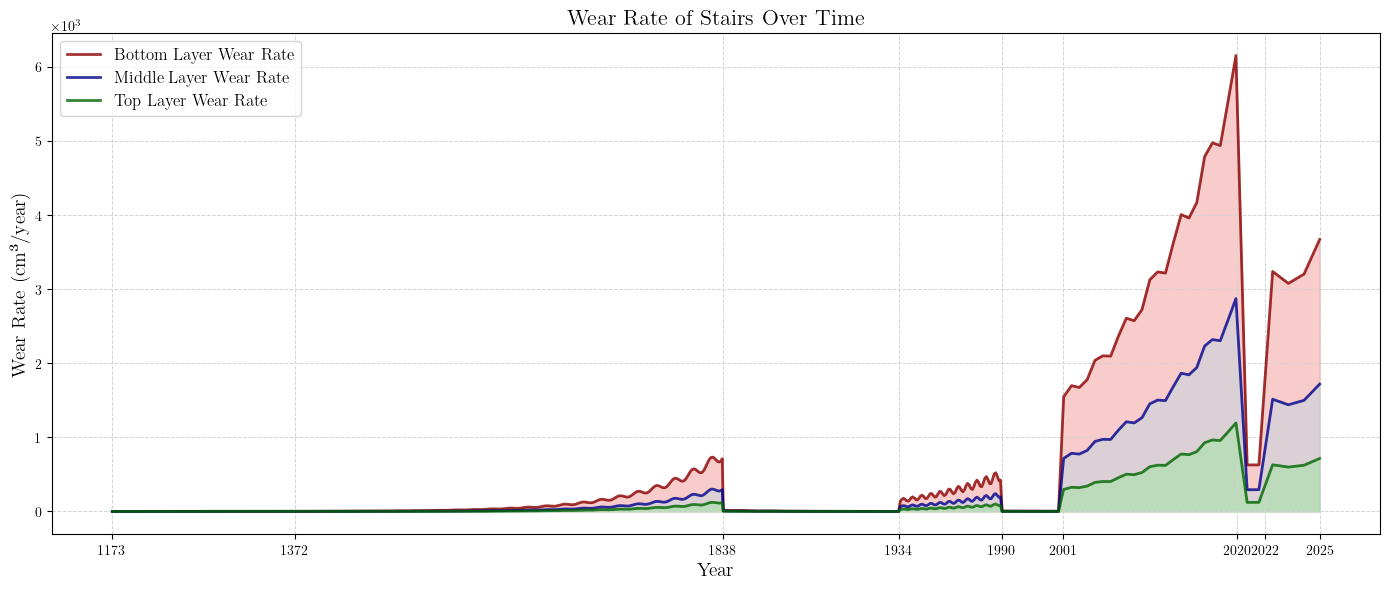

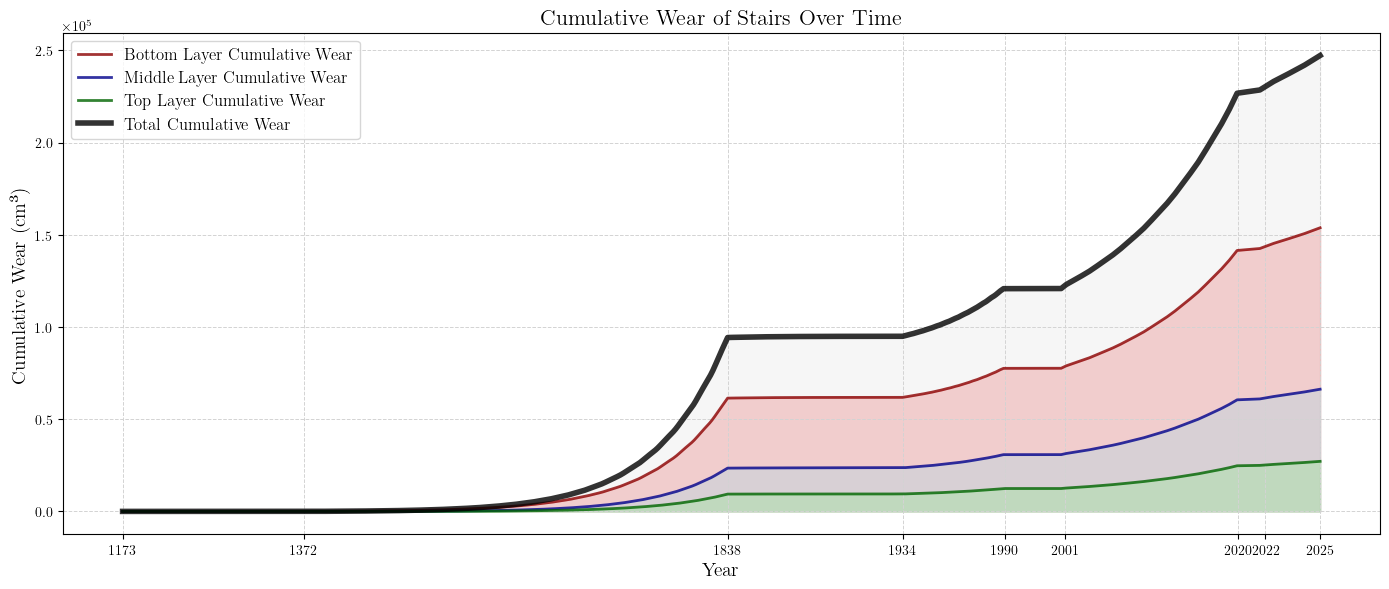

In [68]:
import numpy as np
import matplotlib.pyplot as plt

# 设置 LaTeX 样式
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# 定义时间范围
Time = np.linspace(1173, 2025, 1000)
dt = Time[1] - Time[0]

# 定义年度游客人数模型
def annual_visitors_updated(t):
    def fluctuation(t, A, T):
        return 1 + A * np.sin(2 * np.pi * t / T)

    if t < 1372:
        N0 = 100
        r0 = 1
        A = 0.05
        T = 10
        return (N0 + r0 * (t - 1173)) * fluctuation(t, A, T)
    elif t < 1838:
        N1 = 2000
        r1 = 0.01
        A = 0.1
        T = 20
        return N1 * np.exp(r1 * (t - 1372)) * fluctuation(t, A, T)
    elif t < 1934:
        N2 = 5000
        r2 = 0.005
        A = 0.2
        T = 15
        return N2 * np.exp(r2 * (t - 1838)) * fluctuation(t, A, T)
    elif t < 1990:
        N3 = 100000
        r3 = 0.02
        A = 0.15
        T = 5
        return N3 * np.exp(r3 * (t - 1990)) * fluctuation(t, A, T)
    elif t < 2001:
        N4 = 100
        r4 = 1
        A = 0.05
        T = 10
        return (N4 + r4 * (t - 1173)) * fluctuation(t, A, T)
    elif t < 2020:
        N5 = 300000
        r5 = 0.07
        A = 0.05
        T = 3
        return N5 * np.exp(r5 * (t - 2001)) * fluctuation(t, A, T)
    elif t < 2022:
        N6 = 120000
        return N6
    else:
        N7 = 600000
        r5 = 0.05
        A = 0.1
        T = 5
        return N7 * np.exp(r5 * (t - 2022)) * fluctuation(t, A, T)

# 计算年度游客人数
visitor_counts_updated = [annual_visitors_updated(t) for t in Time]

# 磨损速率和累积磨损计算
def wear_rate_layer(t, layer="bottom"):
    n_bottom, n_middle, n_top = 150, 100, 44
    build_time_bottom, build_time_middle, build_time_top = 1173, 1372, 1399

    if layer == "bottom":
        n = n_bottom
        A_build = (t - build_time_bottom) / 10000
        if t < build_time_bottom:
            return 0
    elif layer == "middle":
        n = n_middle
        A_build = (t - build_time_middle) / 10000
        if t < build_time_middle:
            return 0
    else:
        n = n_top
        A_build = (t - build_time_top) / 10000
        if t < build_time_top:
            return 0

    K = 1e-3 + 1e-5 * t * A_build
    mu = 0.7 - 0.001 * t * A_build
    H = 3.51 - 0.0001 * t * A_build

    def R(t):
        if 1838 <= t <= 1934:
            return 1 / np.exp(0.05 * (t - 1838))
        elif 1990 <= t <= 2001:
            return 1 / np.exp(0.05 * (t - 1990))
        else:
            return 1

    return K * mu * (annual_visitors_updated(t) / H) * n * A_build * R(t)

# 计算每层楼梯的磨损速率
wear_rates_bottom = [wear_rate_layer(t, layer="bottom") for t in Time]
wear_rates_middle = [wear_rate_layer(t, layer="middle") for t in Time]
wear_rates_top = [wear_rate_layer(t, layer="top") for t in Time]

# 累积磨损
def cumulative_wear_rate(wear_rates):
    return np.cumsum(wear_rates) * dt

cumulative_wear_bottom = cumulative_wear_rate(wear_rates_bottom)
cumulative_wear_middle = cumulative_wear_rate(wear_rates_middle)
cumulative_wear_top = cumulative_wear_rate(wear_rates_top)
total_cumulative_wear = cumulative_wear_bottom + cumulative_wear_middle + cumulative_wear_top

# 调整时间比例
segments = [
    (1173, 1372),
    (1372, 1838),
    (1838, 1934),
    (1934, 1990),
    (1990, 2001),
    (2001, 2020),
    (2020, 2022),
    (2022, 2025)
]
segment_weights = [1, 1, 2, 2, 6, 10, 15, 20]
normalized_weights = [w / sum(segment_weights) for w in segment_weights]

segment_mapped_lengths = [
    length * weight for length, weight in zip(
        [end - start for start, end in segments], normalized_weights
    )
]
segment_positions_weighted = [0]
for length in segment_mapped_lengths:
    segment_positions_weighted.append(segment_positions_weighted[-1] + length)

mapped_years_weighted = []
for t in Time:
    for i, (start, end) in enumerate(segments):
        if start <= t < end:
            segment_start = segment_positions_weighted[i]
            segment_end = segment_positions_weighted[i + 1]
            mapped_years_weighted.append(
                segment_start + (t - start) / (end - start) * (segment_end - segment_start)
            )
            break
if len(mapped_years_weighted) < len(Time):
    mapped_years_weighted.append(segment_positions_weighted[-1])


# 绘制磨损速率
plt.figure(figsize=(14, 6))
plt.plot(mapped_years_weighted, wear_rates_bottom, label="Bottom Layer Wear Rate", color='darkred', linewidth=2, alpha=0.8)
plt.fill_between(mapped_years_weighted, wear_rates_bottom, color='lightcoral', alpha=0.4)  # 填充底层

plt.plot(mapped_years_weighted, wear_rates_middle, label="Middle Layer Wear Rate", color='darkblue', linewidth=2, alpha=0.8)
plt.fill_between(mapped_years_weighted, wear_rates_middle, color='lightblue', alpha=0.4)  # 填充中层

plt.plot(mapped_years_weighted, wear_rates_top, label="Top Layer Wear Rate", color='darkgreen', linewidth=2, alpha=0.8)
plt.fill_between(mapped_years_weighted, wear_rates_top, color='lightgreen', alpha=0.4)  # 填充顶层

# 设置横轴刻度和标签
xtick_positions = [segment_positions_weighted[i] for i in range(len(segments) + 1)]
xtick_labels = [str(start) for start, _ in segments] + [str(segments[-1][1])]
plt.xticks(xtick_positions, xtick_labels)

# 设置纵坐标为科学计数法
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

plt.grid(visible=True, which='major', linestyle='--', linewidth=0.7, color='lightgrey')
plt.grid(visible=False, which='minor')
plt.title('Wear Rate of Stairs Over Time', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Wear Rate (cm³/year)', fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# 绘制累积磨损
plt.figure(figsize=(14, 6))
plt.plot(mapped_years_weighted, cumulative_wear_bottom, label="Bottom Layer Cumulative Wear", color='darkred', linewidth=2, alpha=0.8)
plt.fill_between(mapped_years_weighted, cumulative_wear_bottom, color='lightcoral', alpha=0.4)  # 填充底层

plt.plot(mapped_years_weighted, cumulative_wear_middle, label="Middle Layer Cumulative Wear", color='darkblue', linewidth=2, alpha=0.8)
plt.fill_between(mapped_years_weighted, cumulative_wear_middle, color='lightblue', alpha=0.4)  # 填充中层

plt.plot(mapped_years_weighted, cumulative_wear_top, label="Top Layer Cumulative Wear", color='darkgreen', linewidth=2, alpha=0.8)
plt.fill_between(mapped_years_weighted, cumulative_wear_top, color='lightgreen', alpha=0.4)  # 填充顶层

plt.plot(mapped_years_weighted, total_cumulative_wear, label="Total Cumulative Wear", color='black', linewidth=4, alpha=0.8)
plt.fill_between(mapped_years_weighted, total_cumulative_wear, color='lightgrey', alpha=0.2)  # 填充顶层

# 设置横轴刻度和标签
plt.xticks(xtick_positions, xtick_labels)

# 设置纵坐标为科学计数法
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

plt.grid(visible=True, which='major', linestyle='--', linewidth=0.7, color='lightgrey')
plt.grid(visible=False, which='minor')
plt.title('Cumulative Wear of Stairs Over Time', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Cumulative Wear (cm³)', fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()
